<a href="https://colab.research.google.com/github/om-mhaske7/Facebook-live-sellers-analysis/blob/main/Facebook_marketplace_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
ds=pd.read_csv('Facebook_Marketplace_data.csv')

In [ ]:
ds.drop(columns=['Column1','Column2','Column3','Column4'], inplace=True)

In [ ]:
ds['status_published'] = pd.to_datetime(ds['status_published'])
ds['published_day'] = ds['status_published'].dt.day
ds['published_month'] = ds['status_published'].dt.month
ds['published_year'] = ds['status_published'].dt.year
ds['published_hour'] = ds['status_published'].dt.hour
ds['published_weekday'] = ds['status_published'].dt.weekday

ds.drop('status_published', axis=1, inplace=True)


In [ ]:
print(ds.columns)

Index(['status_id', 'status_type', 'num_reactions', 'num_comments',
       'num_shares', 'num_likes', 'num_loves', 'num_wows', 'num_hahas',
       'num_sads', 'num_angrys', 'published_day', 'published_month',
       'published_year', 'published_hour', 'published_weekday'],
      dtype='object')


In [ ]:
num_cols = ['num_reactions', 'num_comments', 'num_shares',
            'num_likes', 'num_loves', 'num_wows',
            'num_hahas', 'num_sads', 'num_angrys','published_day', 'published_month',
       'published_year', 'published_hour', 'published_weekday']



from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
ds[num_cols] = imputer.fit_transform(ds[num_cols])

In [ ]:
print(ds.columns)

Index(['status_id', 'status_type', 'num_reactions', 'num_comments',
       'num_shares', 'num_likes', 'num_loves', 'num_wows', 'num_hahas',
       'num_sads', 'num_angrys', 'published_day', 'published_month',
       'published_year', 'published_hour', 'published_weekday'],
      dtype='object')


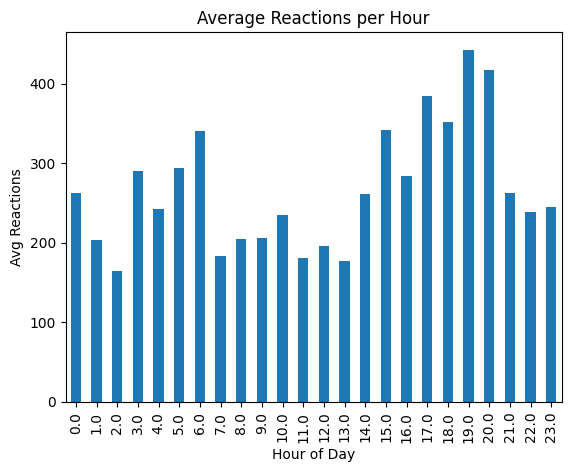

In [ ]:
ds.groupby('published_hour')['num_reactions'].mean().plot(kind='bar')
plt.title('Average Reactions per Hour')
plt.ylabel('Avg Reactions')
plt.xlabel('Hour of Day')
plt.show()

In [ ]:
corr_matrix = ds[['num_reactions','num_comments','num_shares']].corr()
print(corr_matrix)

               num_reactions  num_comments  num_shares
num_reactions       1.000000      0.150843    0.250723
num_comments        0.150843      1.000000    0.640637
num_shares          0.250723      0.640637    1.000000


In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
x = ds[['status_type']]
ct=ColumnTransformer(transformers=[('encoder',OneHotEncoder(sparse_output=False),[0])],remainder='passthrough')
x_encoded = np.array(ct.fit_transform(x))
encoded_col_names = ct.named_transformers_['encoder'].get_feature_names_out(['status_type'])
df_encoded = pd.DataFrame(x_encoded, columns=encoded_col_names)
ds.drop('status_type', axis=1, inplace=True)
ds = pd.concat([df_encoded, ds.reset_index(drop=True)], axis=1)

In [ ]:
print(ds.columns)
print(ds)


Index(['status_type_link', 'status_type_photo', 'status_type_status',
       'status_type_video', 'status_id', 'num_reactions', 'num_comments',
       'num_shares', 'num_likes', 'num_loves', 'num_wows', 'num_hahas',
       'num_sads', 'num_angrys', 'published_day', 'published_month',
       'published_year', 'published_hour', 'published_weekday'],
      dtype='object')
      status_type_link  status_type_photo  status_type_status  \
0                  0.0                0.0                 0.0   
1                  0.0                1.0                 0.0   
2                  0.0                0.0                 0.0   
3                  0.0                1.0                 0.0   
4                  0.0                1.0                 0.0   
...                ...                ...                 ...   
7045               0.0                1.0                 0.0   
7046               0.0                1.0                 0.0   
7047               0.0                1.0  

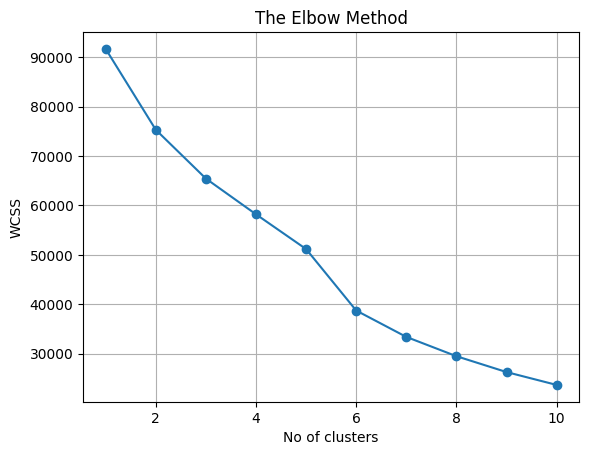

In [ ]:
final_features = ['status_type_link', 'status_type_photo', 'status_type_status',
                  'status_type_video', 'num_reactions', 'num_comments', 'num_shares',
                  'num_likes', 'num_loves', 'num_wows', 'num_hahas', 'num_sads',
                  'num_angrys']

a = ds[final_features]

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(a)

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss, marker='o')
plt.title('The Elbow Method')
plt.xlabel('No of clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()


In [ ]:
for i, val in enumerate(wcss):
    print(f"{i+1} clusters: WCSS = {val}")

1 clusters: WCSS = 91649.99999999943
2 clusters: WCSS = 75295.01493442431
3 clusters: WCSS = 65423.1164000412
4 clusters: WCSS = 58198.4684828752
5 clusters: WCSS = 51167.45012130091
6 clusters: WCSS = 38734.129567133015
7 clusters: WCSS = 33401.968119760735
8 clusters: WCSS = 29499.397811254927
9 clusters: WCSS = 26290.919366923255
10 clusters: WCSS = 23689.685854319596


In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, init='k-means++', random_state=42)
y_kmeans = kmeans.fit_predict(X_scaled)


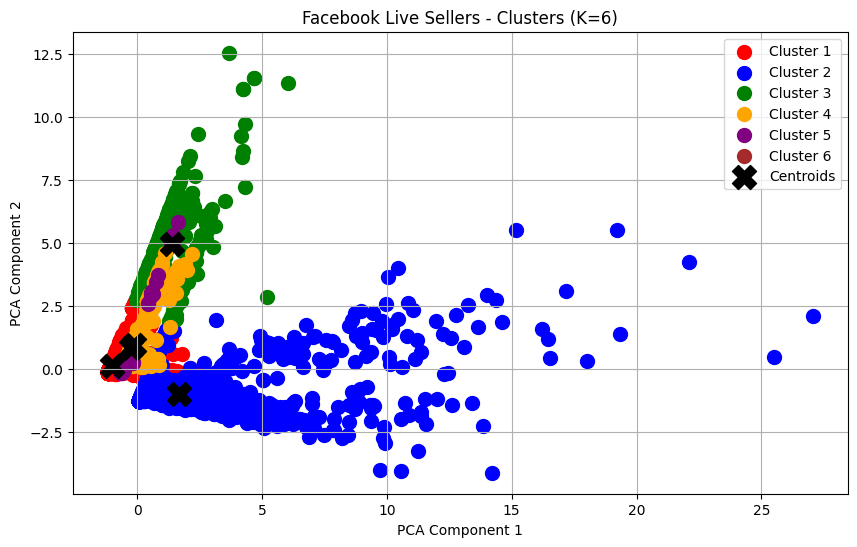

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10,6))
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown']

for i in range(6):
    plt.scatter(X_pca[y_kmeans == i, 0], X_pca[y_kmeans == i, 1],
                s=100, c=colors[i], label=f'Cluster {i+1}')

centroids_2d = pca.transform(kmeans.cluster_centers_)
plt.scatter(centroids_2d[:, 0], centroids_2d[:, 1],
            s=300, c='black', marker='X', label='Centroids')

plt.title('Facebook Live Sellers - Clusters (K=6)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid(True)
plt.show()


status_type_photo     4288.0
status_type_video     2334.0
status_type_status     365.0
status_type_link        63.0
dtype: float64


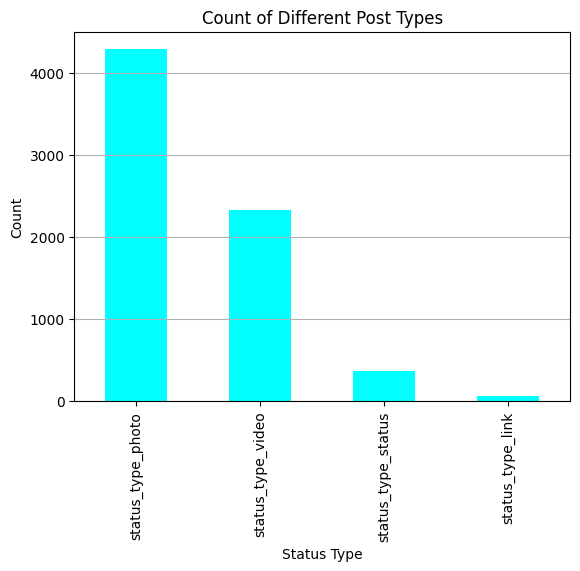

NameError: name 'avg_df' is not defined

In [ ]:
post_counts = ds[['status_type_photo', 'status_type_video', 'status_type_status', 'status_type_link']].sum()
print(post_counts)

post_counts.plot(kind='bar', color='cyan')
plt.title('Count of Different Post Types')
plt.xlabel('Status Type')
plt.ylabel('Count')
plt.grid(axis='y')
plt.show()


Photo:
 num_reactions    181.290345
num_comments      15.993470
num_shares         2.553871
dtype: float64
Video:
 num_reactions    283.409597
num_comments     642.478149
num_shares       115.679949
dtype: float64
Status:
 num_reactions    438.783562
num_comments      36.238356
num_shares         2.558904
dtype: float64
Link:
 num_reactions    370.142857
num_comments       5.698413
num_shares         4.396825
dtype: float64


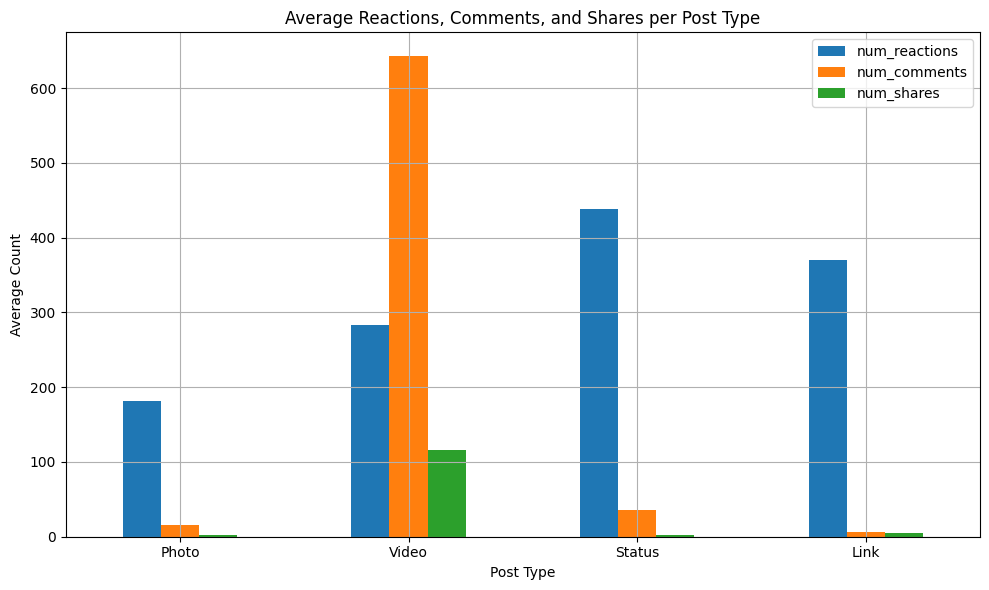

In [ ]:
photo_avg = ds[ds['status_type_photo'] == 1][['num_reactions', 'num_comments', 'num_shares']].mean()
video_avg = ds[ds['status_type_video'] == 1][['num_reactions', 'num_comments', 'num_shares']].mean()
status_avg = ds[ds['status_type_status'] == 1][['num_reactions', 'num_comments', 'num_shares']].mean()
link_avg = ds[ds['status_type_link'] == 1][['num_reactions', 'num_comments', 'num_shares']].mean()

print("Photo:\n", photo_avg)
print("Video:\n", video_avg)
print("Status:\n", status_avg)
print("Link:\n", link_avg)


avg_df = pd.DataFrame({
    'Photo': photo_avg,
    'Video': video_avg,
    'Status': status_avg,
    'Link': link_avg
}).T

avg_df.plot(kind='bar', figsize=(10,6))
plt.title('Average Reactions, Comments, and Shares per Post Type')
plt.ylabel('Average Count')
plt.xlabel('Post Type')
plt.xticks(rotation=0)
plt.grid(True)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()